In [1]:
# !/usr/env python3

'''
Output:
video captioning model itself and produce loss curve

Usage:
main document to train the video captioning model
'''

# set up
from __future__ import print_function
import tensorflow as tf
import pickle
import os
import numpy as np
import logging
import matplotlib.pyplot as plt
from util import *
from model.video_caption import sequence_2_sequence_LSTM
from load_caption_feature import *
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
import gc

%matplotlib inline
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


## Load Data  
load caption Xtrain, Xtest, ytrain, ytest, video_train, video_test and save them. 

In [2]:
# load and save training data
num_frames = 15
size = (224, 224, 3)

# more balanced data
idx_path = os.getcwd() + '/datasets/x_train_ind_above400.npy'
Xtrain_idx = np.load(idx_path)
labels = np.load(os.getcwd() + '/datasets/y_train_mapped_above400.npy')

# if all videos then 
num_videos = len(Xtrain_idx)

tic = datetime.now()
# for clearing memory convenience
model = vgg_16_pretrained()
Xtr, ytr = load_features(model, num_videos, num_frames, Xtrain_idx, labels, size = (224, 224, 3), train_test_flag='train')

processing videos...
process 70/4270
process 140/4270
process 210/4270
process 280/4270
process 350/4270
process 420/4270
process 490/4270
process 560/4270
process 630/4270
process 700/4270
process 770/4270
process 840/4270
process 910/4270
process 980/4270
process 1050/4270
process 1120/4270
process 1190/4270
process 1260/4270
process 1330/4270
process 1400/4270
process 1470/4270
process 1540/4270
process 1610/4270
process 1680/4270
process 1750/4270
process 1820/4270
process 1890/4270
process 1960/4270
process 2030/4270
process 2100/4270
process 2170/4270
process 2240/4270
process 2310/4270
process 2380/4270
process 2450/4270
process 2520/4270
process 2590/4270
process 2660/4270
process 2730/4270
process 2800/4270
process 2870/4270
process 2940/4270
process 3010/4270
process 3080/4270
process 3150/4270
process 3220/4270
process 3290/4270
process 3360/4270
process 3430/4270
process 3500/4270
process 3570/4270
process 3640/4270
process 3710/4270
process 3780/4270
process 3850/4270
proc

In [5]:
# clear memory
# del Xtr
# del ytr
model = None
gc.collect()

0

In [6]:
# load and save test data
num_frames_test = 15
size = (224, 224, 3)

# more balanced data
idx_path = os.getcwd() + '/datasets/x_test_ind_above400.npy'
Xtest_idx = np.load(idx_path)
ytest = np.load(os.getcwd() + '/datasets/y_test_mapped_above400.npy')

# if all videos then 
num_videos_test = len(Xtest_idx)

model = vgg_16_pretrained()
Xte, yte = load_features(model, num_videos_test, num_frames_test, video_idx = Xtest_idx, labels = ytest, size = (224, 224, 3), train_test_flag='test')

processing videos...
process 30/1830
process 60/1830
process 90/1830
process 120/1830
process 150/1830
process 180/1830
process 210/1830
process 240/1830
process 270/1830
process 300/1830
process 330/1830
process 360/1830
process 390/1830
process 420/1830
process 450/1830
process 480/1830
process 510/1830
process 540/1830
process 570/1830
process 600/1830
process 630/1830
process 660/1830
process 690/1830
process 720/1830
process 750/1830
process 780/1830
process 810/1830
process 840/1830
process 870/1830
process 900/1830
process 930/1830
process 960/1830
process 990/1830
process 1020/1830
process 1050/1830
process 1080/1830
process 1110/1830
process 1140/1830
process 1170/1830
process 1200/1830
process 1230/1830
process 1260/1830
process 1290/1830
process 1320/1830
process 1350/1830
process 1380/1830
process 1410/1830
process 1440/1830
process 1470/1830
process 1500/1830
process 1530/1830
process 1560/1830
process 1590/1830
process 1620/1830
process 1650/1830
process 1680/1830
process

In [10]:
# clean memory
# del Xte
# del yte
model = None
gc.collect()

0

In [7]:
curr = os.getcwd() + '/datasets'
vid_ls = np.load(curr + '/videoIdtrain_allCap_15frames.npy')

In [11]:
Xtr = np.load(curr + '/Xtrain_allCap_15frames.npy')

In [18]:
Xtr = Xtr.reshape((-1, 15, 4096))
print('Xtrain shape: ', Xtr.shape)
assert Xtr.shape[0] == len(vid_ls)
input_frames = {}
for i in range(Xtr.shape[0]):
    vid = vid_ls[i]
    input_frames[vid] = Xtr[i]
# save input_frames
import pickle
pickle.dump(input_frames, open(curr+ '/input_frames_train.pickle', 'wb'))

Xtrain shape:  (4270, 15, 4096)


In [20]:
Xte = np.load(curr + '/Xtest_allCap_15frames.npy')
Xte = Xte.reshape((-1, 15, 4096))
print('Xtest shape: ', Xte.shape)
vid_test = np.load(curr + '/videoIdtest_allCap_15frames.npy')
assert Xte.shape[0] == len(vid_test)
input_frames_test = {}
for i in range(Xte.shape[0]):
    vid = vid_test[i]
    input_frames_test[vid] = Xtr[i]
# save input_frames
import pickle
pickle.dump(input_frames_test, open(curr+ '/input_frames_test.pickle', 'wb'))

Xtest shape:  (1830, 15, 4096)


## Model setup and train

### Model Configuration and Parameters

In [2]:
# define parameters
lr = 1e-5
hidden_size = 100
state_size = 100
batch_size = 64
voc_size = 6169
epoch = 200
word_dim = 50

logging.basicConfig(level=logging.INFO)
#=======Change These===============================
tf.app.flags.DEFINE_string("model_name", "baseline_1", "name of the model")
tf.app.flags.DEFINE_integer("state_size", state_size, "Size of each model layer.")
tf.app.flags.DEFINE_float("learning_rate", lr, "Base Learning rate.")
#==================================================

tf.app.flags.DEFINE_float("input_size", 4096, "input size for each frame")
tf.app.flags.DEFINE_integer("batch_size", batch_size, "how many videos put per run")
tf.app.flags.DEFINE_integer("max_sentence_length", 20, "maximum captioning sentence length")
tf.app.flags.DEFINE_integer("word_vector_size", word_dim, "word embedding dimension default is 25 for twitter glove")
tf.app.flags.DEFINE_integer("voc_size", voc_size, "vocabulary size")
tf.app.flags.DEFINE_integer("n_epochs", epoch, "number of epoch to run")
tf.app.flags.DEFINE_integer("num_frames", 15, "number of frames per video")
tf.app.flags.DEFINE_integer("hidden_size", hidden_size, "output size of LSTM encoder and decoder")
FLAGS = tf.app.flags.FLAGS        

### Load Training Data

In [4]:
def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

curPath = os.getcwd()
dataPath = curPath + "/datasets/"

# only pick first 100 for debugging purpose
# load data
sample_size = 4270
wvector_dim = 50
is_training = True
input_frames_train, captions_train, \
        word_dict, word2Index, index2Word = load_caption_data(sample_size, dataPath, train = is_training)
word_embedding = word_embedding_array(word_dict, wvector_dim, word2Index) 
print('Finish loading training data!')

Finish loading training data!


### Build Model Graph

In [23]:
# build model graph
tf.reset_default_graph()
model = sequence_2_sequence_LSTM(word_embedding, FLAGS)
model.build()

start building model ...
total number of parameter 2402269


In [5]:
# check variables
for v in tf.trainable_variables():
    print(v)

<tf.Variable 'LSTM_seq2seq/encoder/basic_lstm_cell/weights:0' shape=(4196, 400) dtype=float32_ref>
<tf.Variable 'LSTM_seq2seq/encoder/basic_lstm_cell/biases:0' shape=(400,) dtype=float32_ref>
<tf.Variable 'LSTM_seq2seq/decoder/basic_lstm_cell/weights:0' shape=(250, 400) dtype=float32_ref>
<tf.Variable 'LSTM_seq2seq/decoder/basic_lstm_cell/biases:0' shape=(400,) dtype=float32_ref>
<tf.Variable 'LSTM_seq2seq/decoder/hidden_to_scores/kernel:0' shape=(100, 6169) dtype=float32_ref>
<tf.Variable 'LSTM_seq2seq/decoder/hidden_to_scores/bias:0' shape=(6169,) dtype=float32_ref>


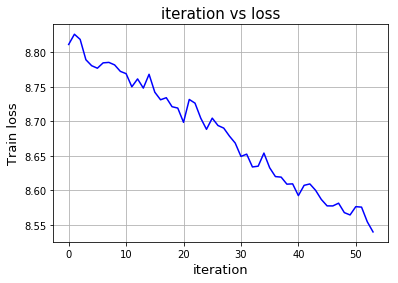

  1/200 [..............................] - ETA: 2797s - train loss: 8.6813 - dev loss: 8.4895

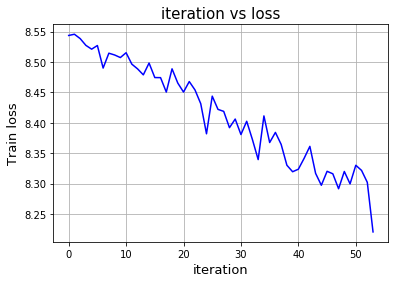

  2/200 [..............................] - ETA: 2445s - train loss: 8.4141 - dev loss: 8.2533

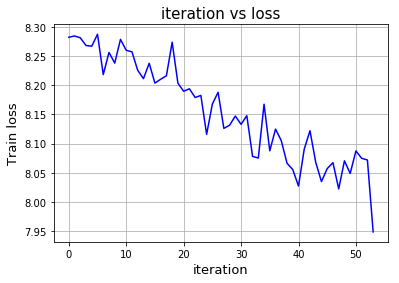

  3/200 [..............................] - ETA: 2319s - train loss: 8.1559 - dev loss: 7.9782

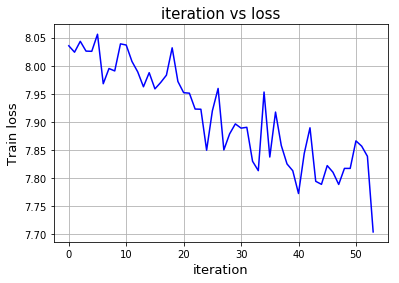

  4/200 [..............................] - ETA: 2252s - train loss: 7.9120 - dev loss: 7.7237

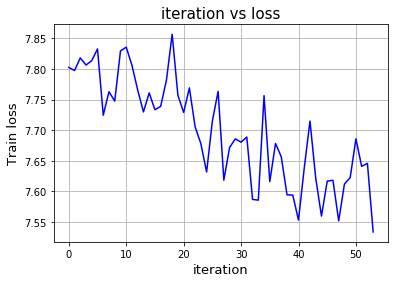

  5/200 [..............................] - ETA: 2207s - train loss: 7.6984 - dev loss: 7.5008

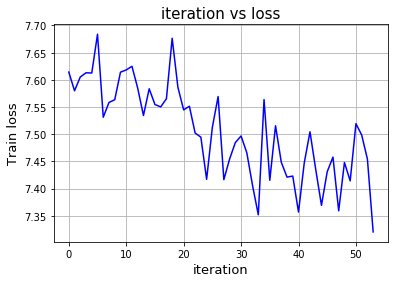

  6/200 [..............................] - ETA: 2175s - train loss: 7.5060 - dev loss: 7.3093

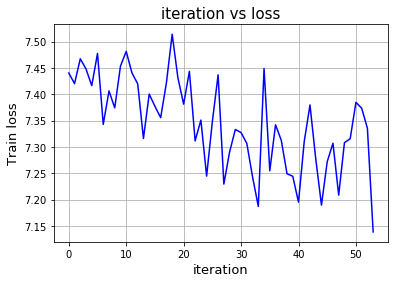

  7/200 [>.............................] - ETA: 2149s - train loss: 7.3461 - dev loss: 7.1459

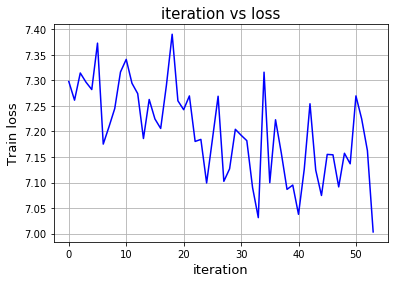

  8/200 [>.............................] - ETA: 2127s - train loss: 7.2002 - dev loss: 7.0015

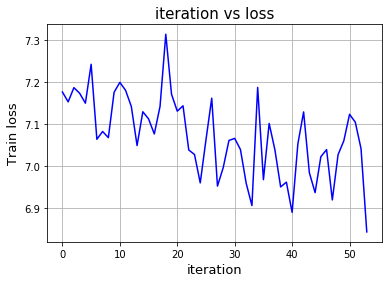

  9/200 [>.............................] - ETA: 2106s - train loss: 7.0714 - dev loss: 6.8691

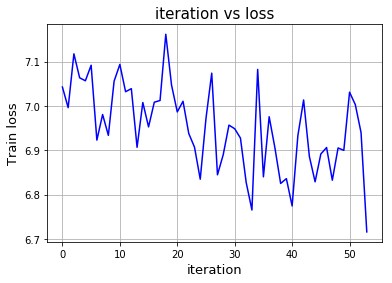

In [ ]:
# run training mode
with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    out = model.train(sess, (input_frames_train, captions_train), verbose = True)

In [9]:
# unpack
val_loss, tr_loss, tr_pred, val_pred, train_vid, val_vid = out

### Plot Learning Curves

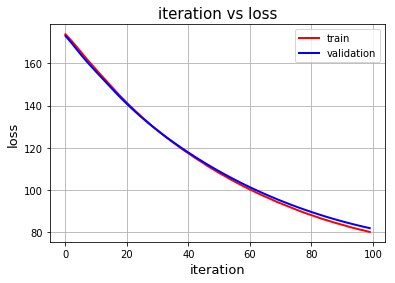

In [10]:
# plot learning curve
plt.plot(range(len(tr_loss)), tr_loss, 'r-', linewidth = 2, label = 'train')
plt.plot(range(len(val_loss)), val_loss, 'b-', linewidth = 2, label = 'validation')
plt.grid()
plt.xlabel('iteration', fontsize = 13)
plt.ylabel('loss', fontsize = 13)
plt.title('iteration vs loss', fontsize = 15)
plt.legend()
plt.savefig(os.getcwd() + '/output/caption_learning_curve.png')

In [10]:
# check captions
batch_size = 24
# sample = tr_pred[idx] # training
# # sample = val_pred[idx] # validation 
# words = []
# embed_train = False # whether train embedding word

captions = {k: v for k, v in captions_train}
# caption check
for j in range(batch_size):
    words = []
    trues = []
    sample = tr_pred[j]
    vid = train_vid[j]
    cap = captions[vid]
    for idx, i in enumerate(sample):
        word = index2Word[i]
        true = index2Word[cap[idx]]
        if word not in ['<START>', '<END>', '<pad>']:
            words.append(word)
        if true not in ['<START>', '<END>', '<pad>']:
            trues.append(true)   
    print('Pred Caption: ', ' '.join(w for w in words))
    print('True Caption: ', ' '.join(t for t in trues))
    print('-'*50)

Pred Caption:  a a a a a
True Caption:  two children are fighting with small sticks
--------------------------------------------------
Pred Caption:  a a a and
True Caption:  a video game is played
--------------------------------------------------
Pred Caption:  a a a a a and in and and a
True Caption:  a cabinet is opening its doors to reveal what is inside it
--------------------------------------------------
Pred Caption:  a a a the and
True Caption:  description of a green paper airplane
--------------------------------------------------
Pred Caption:  a a a
True Caption:  people are performing a party
--------------------------------------------------
Pred Caption:  a and a a a
True Caption:  dark outdoor people all around
--------------------------------------------------
Pred Caption:  a and and and and the the a
True Caption:  two men are talking each other while one women seating beside one man
--------------------------------------------------
Pred Caption:  a a the
True Cap

### Check Test Prediction and Evaluation

In [11]:
len(tr_pred)

24